In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Load the data
#file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
file_path = "/Users/doughnut/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Clean up
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -------------------------------------------------------------------
# Filter to just the two items of interest plus any others you need
items_to_include = [
    '73287',   # Old test (to be replaced)
    '73292',   # New test (replacement)
    # ... plus any of your other groups if you still need them ...
]
filtered_data = data[data['Item'].isin(items_to_include)].copy()

# (If you still need your grouping logic, insert it here—
# but for pure replacement you can skip straight to the two-series.)

# -------------------------------------------------------------------
# Prepare old vs new series, aligned by month
old_ts = (
    filtered_data[filtered_data['Item']=='73287']['Value']
    .resample('ME').sum()
)
new_ts = (
    filtered_data[filtered_data['Item']=='73292']['Value']
    .resample('ME').sum()
)

fp_df = pd.DataFrame({
    'old': old_ts,
    'new': new_ts
}).dropna()

# Compute the observed share of the new test
fp_df['share_new'] = fp_df['new'] / (fp_df['new'] + fp_df['old'])

# Create a time axis in years from the first observation
fp_df['t'] = np.arange(len(fp_df)) / 12.0

# Define the Fisher–Pry replacement model: S(t) = 1 / (1 + exp(–b*(t – t0)))
def fisher_pry(t, b, t0):
    return 1.0 / (1.0 + np.exp(-b * (t - t0)))

# Initial guesses: moderate growth rate, mid-point at half the series
p0 = [1.0, fp_df['t'].median()]

# Fit the model
params, cov = curve_fit(
    fisher_pry,
    fp_df['t'],
    fp_df['share_new'],
    p0=p0,
    bounds=([0, 0], [np.inf, np.max(fp_df['t']) + 5]),
    maxfev=10000
)

b_fit, t0_fit = params

# Predict fitted share
fp_df['share_fit'] = fisher_pry(fp_df['t'], b_fit, t0_fit)

# Plot observed vs fitted
plt.figure(figsize=(10, 5))
plt.plot(fp_df.index, fp_df['share_new'], 'o', label='Observed share of 73292')
plt.plot(fp_df.index, fp_df['share_fit'], '-', label='Fisher–Pry fit')
plt.xlabel('Month')
plt.ylabel('Share of new test')
plt.title('Fisher–Pry Replacement: 73287 → 73292')
plt.legend()
plt.tight_layout()
plt.show()

# Print fitted parameters
print(f"Fisher–Pry parameters:\n  b (growth rate) = {b_fit:.3f}\n  t0 (inflection at year) = {t0_fit:.3f} years from start")

# Optional: goodness-of-fit
r2 = 1 - np.sum((fp_df['share_new'] - fp_df['share_fit'])**2) / np.sum((fp_df['share_new'] - fp_df['share_new'].mean())**2)
print(f"R² of fit: {r2:.3f}")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/doughnut/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# -----------------------------------------------------------------------------
# 1. Load & clean data
# -----------------------------------------------------------------------------
# file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/" \
#            "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/" \
#            "MBSGeneticsBenefit_202502.feather"
file_path = "/Users/doughnut/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

# Strip whitespace from "Item" and parse dates
data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -----------------------------------------------------------------------------
# 2. Filter to the two items for replacement analysis
# -----------------------------------------------------------------------------
items_to_include = ['73287', '73292']  # old → new
filtered = data[data['Item'].isin(items_to_include)].copy()

# Resample to month-end, summing counts
old_ts = (filtered[filtered['Item']=='73287']['Value']
          .resample('ME').sum())
new_ts = (filtered[filtered['Item']=='73292']['Value']
          .resample('ME').sum())

# Build DataFrame of aligned series
fp_df = pd.DataFrame({'old': old_ts, 'new': new_ts}).dropna()

# Compute share of the new test
fp_df['share_new'] = fp_df['new'] / (fp_df['new'] + fp_df['old'])

# Time axis in years from start
fp_df['t'] = np.arange(len(fp_df)) / 12.0

# -----------------------------------------------------------------------------
# 3. Define the Norton–Bass replacement model
#    S(t) = [1 – exp(–(p+q)*(t – t0))]
#           / [1 + (q/p) * exp(–(p+q)*(t – t0))]
# -----------------------------------------------------------------------------
def norton_bass(t, p, q, t0):
    T = t - t0
    expo = np.exp(-(p + q) * T)
    share = (1 - expo) / (1 + (q / p) * expo)
    # clamp share to 0 before t0
    return np.where(T < 0, 0.0, share)

# -----------------------------------------------------------------------------
# 4. Fit to data
# -----------------------------------------------------------------------------
# Initial guesses: p small, q moderate, t0 at midpoint
p0 = [0.1, 0.5, fp_df['t'].median()]
bounds = (
    [1e-6, 1e-6, 0],                     # p>0, q>0, t0≥0
    [5.0,  5.0, fp_df['t'].max() * 1.2]   # generous upper limits
)
params, _ = curve_fit(
    norton_bass,
    fp_df['t'],
    fp_df['share_new'],
    p0=p0,
    bounds=bounds,
    maxfev=10000
)
p_fit, q_fit, t0_fit = params

# Compute fitted series
fp_df['share_fit'] = norton_bass(fp_df['t'], p_fit, q_fit, t0_fit)

# -----------------------------------------------------------------------------
# 5. Plot results
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(fp_df.index, fp_df['share_new'], 'o', label='Observed share of 73292')
plt.plot(fp_df.index, fp_df['share_fit'], '-', label='Norton–Bass fit')
plt.axvline(fp_df.index[int(t0_fit*12)], color='gray', linestyle='--',
            label=f'Inflection ≈ {t0_fit:.2f} yr')
plt.xlabel('Month')
plt.ylabel('Share of new test')
plt.title('Norton–Bass Replacement Curve: 73287 → 73292')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6. Report fitted parameters and goodness-of-fit
# -----------------------------------------------------------------------------
print("Norton–Bass fitted parameters:")
print(f"  p (innovation rate) = {p_fit:.4f}")
print(f"  q (imitation rate)  = {q_fit:.4f}")
print(f"  t0 (inflection yr)  = {t0_fit:.4f}")

r2_nb = 1 - np.sum((fp_df['share_new'] - fp_df['share_fit'])**2) \
             / np.sum((fp_df['share_new'] - fp_df['share_new'].mean())**2)
print(f"R² of Norton–Bass fit: {r2_nb:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/doughnut/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather'

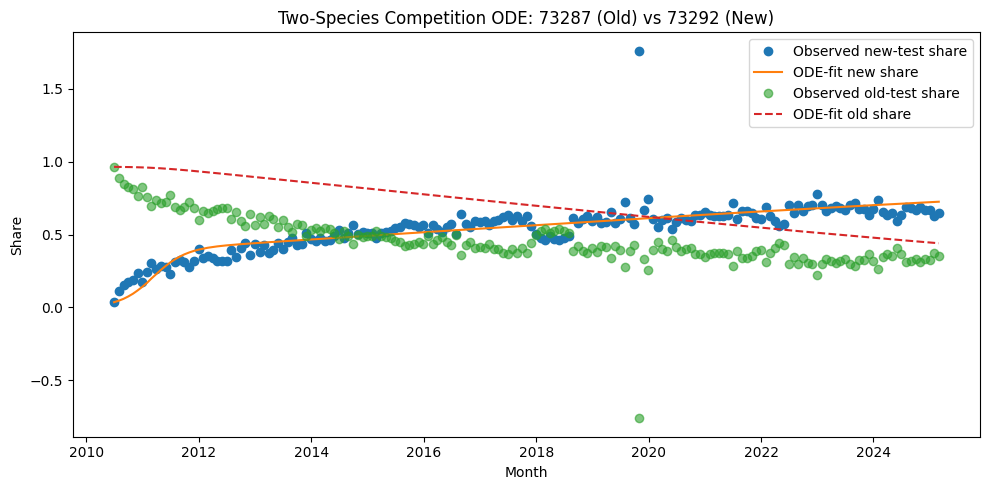

Fitted competition parameters:
  α (displacement rate)       = 0.0992
  β (new-test growth rate)   = 8.5178
  γ (competitive suppression) = 5.2540
R² (new share) = 0.632
R² (old share) = -1.656


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import least_squares
from sklearn.metrics import r2_score

# -----------------------------------------------------------------------------
# 1. Load & clean data
# -----------------------------------------------------------------------------
# file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/" \
#            "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/" \
#            "MBSGeneticsBenefit_202502.feather"
file_path = "/Users/doughnut/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -----------------------------------------------------------------------------
# 2. Extract & align old vs new
# -----------------------------------------------------------------------------
old_ts = (
    data.loc[data['Item']=='73287', 'Value']
    .resample('ME').sum()
)
new_ts = (
    data.loc[data['Item']=='73292', 'Value']
    .resample('ME').sum()
)

df = pd.DataFrame({'old': old_ts, 'new': new_ts}).dropna()

# Compute shares (so old + new = 1)
df['N'] = df['new'] / (df['old'] + df['new'])
df['O'] = 1 - df['N']

# Time axis in years from start
df['t'] = np.arange(len(df)) / 12.0

# -----------------------------------------------------------------------------
# 3. Define the competition ODE system
# -----------------------------------------------------------------------------
def competition(y, t, alpha, beta, gamma):
    O, N = y
    dO = -alpha * O * N
    dN = beta * N * (1 - N) - gamma * O * N
    return [dO, dN]

# -----------------------------------------------------------------------------
# 4. Residual function for least-squares
# -----------------------------------------------------------------------------
t_vec = df['t'].values
obs_N = df['N'].values
y0    = [df['O'].iloc[0], df['N'].iloc[0]]

def resid(params):
    alpha, beta, gamma = params
    sol = odeint(competition, y0, t_vec, args=(alpha, beta, gamma))
    N_sim = sol[:, 1]
    return N_sim - obs_N

# -----------------------------------------------------------------------------
# 5. Fit α, β, γ (all constrained ≥0)
# -----------------------------------------------------------------------------
initial = [0.1, 0.1, 0.1]
bounds  = (0, np.inf)

res = least_squares(resid, initial, bounds=bounds, max_nfev=10000)
alpha_fit, beta_fit, gamma_fit = res.x

# Simulate with fitted parameters
sol = odeint(competition, y0, t_vec, args=(alpha_fit, beta_fit, gamma_fit))
df['N_fit'] = sol[:, 1]
df['O_fit'] = sol[:, 0]

# -----------------------------------------------------------------------------
# 6. Plot observed vs modelled
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['N'],  'o', label='Observed new-test share')
plt.plot(df.index, df['N_fit'], '-', label='ODE-fit new share')
plt.plot(df.index, df['O'],  'o', label='Observed old-test share', alpha=0.6)
plt.plot(df.index, df['O_fit'], '--', label='ODE-fit old share')
plt.xlabel('Month')
plt.ylabel('Share')
plt.title('Two-Species Competition ODE: 73287 (Old) vs 73292 (New)')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. Report parameters & goodness-of-fit
# -----------------------------------------------------------------------------
print("Fitted competition parameters:")
print(f"  α (displacement rate)       = {alpha_fit:.4f}")
print(f"  β (new-test growth rate)   = {beta_fit:.4f}")
print(f"  γ (competitive suppression) = {gamma_fit:.4f}")

r2_new = r2_score(df['N'], df['N_fit'])
r2_old = r2_score(df['O'], df['O_fit'])
print(f"R² (new share) = {r2_new:.3f}")
print(f"R² (old share) = {r2_old:.3f}")


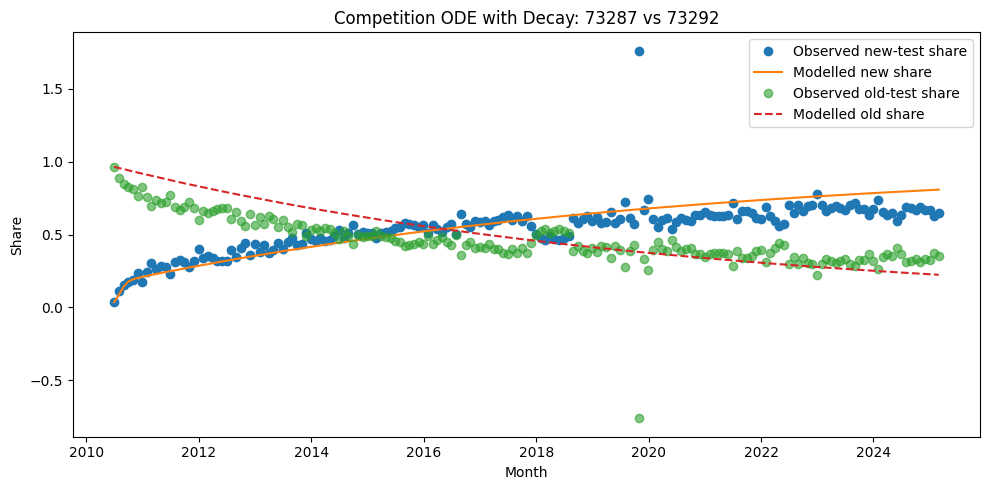

Fitted parameters:
  δ (old independent decay)   = 0.0998
  α (displacement rate)       = 0.0000
  β (new-test growth rate)    = 89.0796
  γ (competitive suppression) = 76.3145
R² (new share) = 0.537
R² (old share) = 0.338


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import least_squares
from sklearn.metrics import r2_score

# -----------------------------------------------------------------------------
# 1. Load & clean data
# -----------------------------------------------------------------------------
# file_path = "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/" \
#            "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/" \
#            "MBSGeneticsBenefit_202502.feather"
file_path = "/Users/doughnut/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/MBSGeneticsBenefit_202502.feather"
data = pd.read_feather(file_path)

data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -----------------------------------------------------------------------------
# 2. Extract & align old vs new
# -----------------------------------------------------------------------------
old_ts = (
    data.loc[data['Item']=='73287', 'Value']
    .resample('ME').sum()
)
new_ts = (
    data.loc[data['Item']=='73292', 'Value']
    .resample('ME').sum()
)

df = pd.DataFrame({'old': old_ts, 'new': new_ts}).dropna()

# Compute shares so that old + new = 1
df['N'] = df['new'] / (df['old'] + df['new'])
df['O'] = 1 - df['N']

# Time axis in years from start
df['t'] = np.arange(len(df)) / 12.0

# -----------------------------------------------------------------------------
# 3. Define the extended competition ODE with independent decay δ for old
# -----------------------------------------------------------------------------
def competition_decay(y, t, delta, alpha, beta, gamma):
    O, N = y
    dO = -delta * O - alpha * O * N
    dN = beta * N * (1 - N) - gamma * O * N
    return [dO, dN]

# -----------------------------------------------------------------------------
# 4. Residual function for least-squares fitting of δ, α, β, γ
# -----------------------------------------------------------------------------
t_vec = df['t'].values
obs_N = df['N'].values
obs_O = df['O'].values
y0    = [df['O'].iloc[0], df['N'].iloc[0]]

def resid(params):
    delta, alpha, beta, gamma = params
    sol = odeint(competition_decay, y0, t_vec, args=(delta, alpha, beta, gamma))
    N_sim = sol[:, 1]
    O_sim = sol[:, 0]
    # Combine residuals for new and old shares
    return np.concatenate([N_sim - obs_N, O_sim - obs_O])

# -----------------------------------------------------------------------------
# 5. Fit parameters (all constrained ≥ 0)
# -----------------------------------------------------------------------------
initial = [0.01, 0.05, 0.5, 0.5]  # [δ, α, β, γ]
bounds  = (0, np.inf)

res = least_squares(resid, initial, bounds=bounds, max_nfev=20000)
delta_fit, alpha_fit, beta_fit, gamma_fit = res.x

# Simulate with fitted parameters
sol = odeint(competition_decay, y0, t_vec, args=(delta_fit, alpha_fit, beta_fit, gamma_fit))
df['N_fit'] = sol[:, 1]
df['O_fit'] = sol[:, 0]

# -----------------------------------------------------------------------------
# 6. Plot observed vs modelled shares
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['N'],  'o', label='Observed new-test share')
plt.plot(df.index, df['N_fit'], '-', label='Modelled new share')
plt.plot(df.index, df['O'],  'o', label='Observed old-test share', alpha=0.6)
plt.plot(df.index, df['O_fit'], '--', label='Modelled old share')
plt.xlabel('Month')
plt.ylabel('Share')
plt.title('Competition ODE with Decay: 73287 vs 73292')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. Report fitted parameters & goodness-of-fit
# -----------------------------------------------------------------------------
print("Fitted parameters:")
print(f"  δ (old independent decay)   = {delta_fit:.4f}")
print(f"  α (displacement rate)       = {alpha_fit:.4f}")
print(f"  β (new-test growth rate)    = {beta_fit:.4f}")
print(f"  γ (competitive suppression) = {gamma_fit:.4f}")

r2_new = r2_score(df['N'], df['N_fit'])
r2_old = r2_score(df['O'], df['O_fit'])
print(f"R² (new share) = {r2_new:.3f}")
print(f"R² (old share) = {r2_old:.3f}")


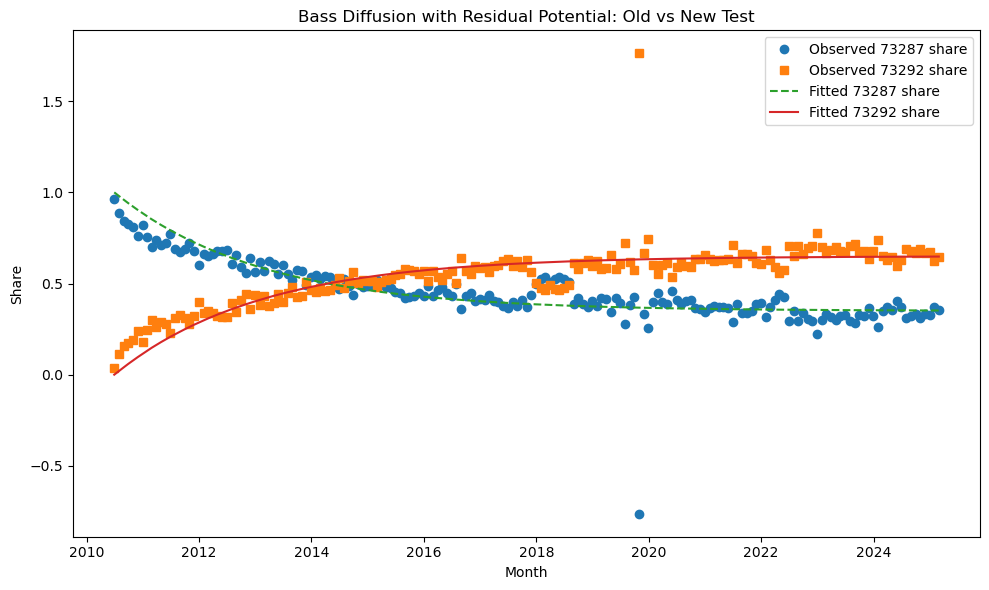

Bass w/ residual fitted parameters:
  p (clinician innovation)     = 0.3858 /yr
  q (clinician imitation)      = 0.0000 /yr
  M (max replaceable fraction) = 0.6502 → residual old = 0.3498
  k (total uptake rate)        = 0.3858 /yr
  t₅₀ (time to 50% of M)       = 1.80 years from start
R² (new share) = 0.633
R² (old share) = 0.633


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# -----------------------------------------------------------------------------
# 1. Load & clean data
# -----------------------------------------------------------------------------
file_path = (
    "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/"
    "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/"
    "MBSGeneticsBenefit_202502.feather"
)
data = pd.read_feather(file_path)

data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -----------------------------------------------------------------------------
# 2. Extract & align old vs new
# -----------------------------------------------------------------------------
old_ts = (
    data.loc[data['Item']=='73287','Value']
    .resample('ME').sum()
)
new_ts = (
    data.loc[data['Item']=='73292','Value']
    .resample('ME').sum()
)

df = pd.DataFrame({'old': old_ts, 'new': new_ts}).dropna()

# Compute shares so that old + new = 1
df['share_new'] = df['new'] / (df['old'] + df['new'])
df['share_old'] = 1 - df['share_new']

# Time axis in years from start
df['t'] = np.arange(len(df)) / 12.0

# -----------------------------------------------------------------------------
# 3. Define the “Bass with residual” model
#    share_new(t) = M * [1 - exp(-(p+q)*t)] / [1 + (q/p) * exp(-(p+q)*t)]
# -----------------------------------------------------------------------------
def bass_residual(t, p, q, M):
    expo = np.exp(-(p + q) * t)
    return M * (1 - expo) / (1 + (q / p) * expo)

# -----------------------------------------------------------------------------
# 4. Fit p, q, M to the observed share series
# -----------------------------------------------------------------------------
t_vals = df['t'].values
y_vals = df['share_new'].values

# Safe initial guess for M strictly < 1.0
M0 = min(y_vals.max(), 0.95)
p0 = [0.05, 0.3, M0]
bounds = ([1e-6, 1e-6, 1e-6], [5.0, 5.0, 1.0])

params, _ = curve_fit(
    bass_residual,
    t_vals,
    y_vals,
    p0=p0,
    bounds=bounds,
    maxfev=10000
)
p_fit, q_fit, M_fit = params

# Compute fitted shares
df['fit_new'] = bass_residual(t_vals, p_fit, q_fit, M_fit)
df['fit_old'] = 1 - df['fit_new']

# -----------------------------------------------------------------------------
# 5. Compute additional metrics
# -----------------------------------------------------------------------------
k = p_fit + q_fit
# half-adoption time t₅₀
if q_fit > 0:
    t50 = np.log(2 + q_fit / p_fit) / k
else:
    t50 = np.log(2) / p_fit

# -----------------------------------------------------------------------------
# 6. Plot observed vs fitted shares
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['share_old'], 'o', label='Observed 73287 share')
plt.plot(df.index, df['share_new'], 's', label='Observed 73292 share')
plt.plot(df.index, df['fit_old'],  '--', label='Fitted 73287 share')
plt.plot(df.index, df['fit_new'],  '-',  label='Fitted 73292 share')
plt.xlabel('Month')
plt.ylabel('Share')
plt.title('Bass Diffusion with Residual Potential: Old vs New Test')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. Report fitted parameters & goodness-of-fit
# -----------------------------------------------------------------------------
print("Bass w/ residual fitted parameters:")
print(f"  p (clinician innovation)     = {p_fit:.4f} /yr")
print(f"  q (clinician imitation)      = {q_fit:.4f} /yr")
print(f"  M (max replaceable fraction) = {M_fit:.4f} → residual old = {1-M_fit:.4f}")
print(f"  k (total uptake rate)        = {k:.4f} /yr")
print(f"  t₅₀ (time to 50% of M)       = {t50:.2f} years from start")

r2_new = r2_score(df['share_new'], df['fit_new'])
r2_old = r2_score(df['share_old'], df['fit_old'])
print(f"R² (new share) = {r2_new:.3f}")
print(f"R² (old share) = {r2_old:.3f}")


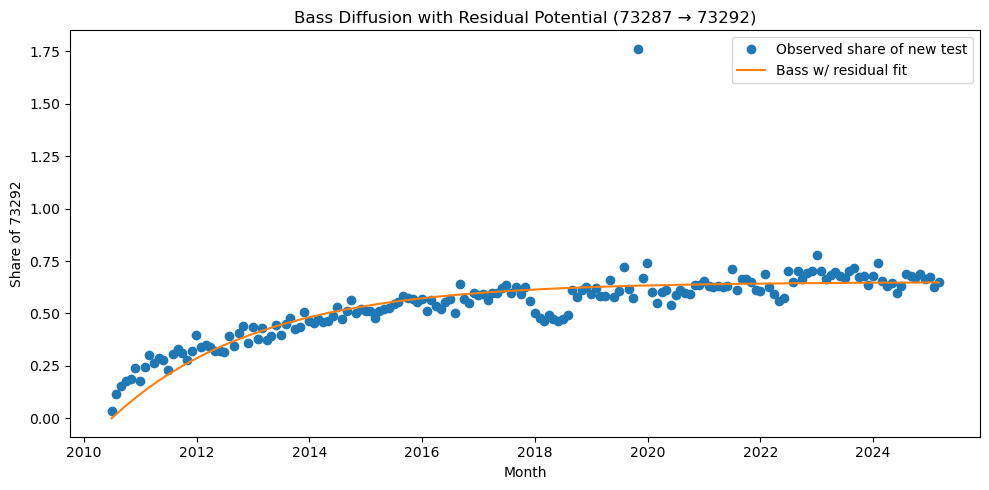

Bass w/ residual fitted parameters:
  p (clinician innovation)     = 0.3858 /yr
  q (clinician imitation)      = 0.0000 /yr
  M (max replaceable fraction) = 0.6502 (→ residual old = 0.3498)
R² of fit: 0.633


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# -----------------------------------------------------------------------------
# 1. Load & clean data
# -----------------------------------------------------------------------------
file_path = (
    "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/"
    "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/"
    "MBSGeneticsBenefit_202502.feather"
)
data = pd.read_feather(file_path)

data['Item'] = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -----------------------------------------------------------------------------
# 2. Extract & align old vs new
# -----------------------------------------------------------------------------
old_ts = (data.loc[data['Item']=='73287','Value']
          .resample('ME').sum())
new_ts = (data.loc[data['Item']=='73292','Value']
          .resample('ME').sum())

df = pd.DataFrame({'old': old_ts, 'new': new_ts}).dropna()

# Compute the observed share of the new test among the two
df['share_new'] = df['new'] / (df['old'] + df['new'])

# Create a time axis in years from start
df['t'] = np.arange(len(df)) / 12.0

# -----------------------------------------------------------------------------
# 3. Define the “Bass with residual” model
#    share_new(t) = M * [1 - exp(-(p+q)*t)] / [1 + (q/p) * exp(-(p+q)*t)]
# -----------------------------------------------------------------------------
def bass_residual(t, p, q, M):
    expo = np.exp(-(p + q) * t)
    return M * (1 - expo) / (1 + (q / p) * expo)

# -----------------------------------------------------------------------------
# 4. Fit p, q, M to the observed share series
# -----------------------------------------------------------------------------
t_vals = df['t'].values
y_vals = df['share_new'].values

# Compute a safe initial M strictly <1.0
M0 = min(y_vals.max(), 0.95)

# Initial guesses: p small, q moderate, M = M0
p0 = [0.05, 0.3, M0]
bounds = ([1e-6, 1e-6, 1e-6],   # p>0, q>0, M>0
          [5.0,  5.0,  1.0])    # p≤5, q≤5, M≤1

params, _ = curve_fit(
    bass_residual,
    t_vals,
    y_vals,
    p0=p0,
    bounds=bounds,
    maxfev=10000
)
p_fit, q_fit, M_fit = params

# Compute fitted curve
df['share_fit'] = bass_residual(t_vals, p_fit, q_fit, M_fit)

# -----------------------------------------------------------------------------
# 5. Plot observed vs fitted
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['share_new'], 'o',   label='Observed share of new test')
plt.plot(df.index, df['share_fit'], '-',   label='Bass w/ residual fit')
plt.xlabel('Month')
plt.ylabel('Share of 73292')
plt.title('Bass Diffusion with Residual Potential (73287 → 73292)')
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6. Report parameters & goodness-of-fit
# -----------------------------------------------------------------------------
print("Bass w/ residual fitted parameters:")
print(f"  p (clinician innovation)     = {p_fit:.4f} /yr")
print(f"  q (clinician imitation)      = {q_fit:.4f} /yr")
print(f"  M (max replaceable fraction) = {M_fit:.4f} (→ residual old = {1-M_fit:.4f})")

r2 = r2_score(df['share_new'], df['share_fit'])
print(f"R² of fit: {r2:.3f}")


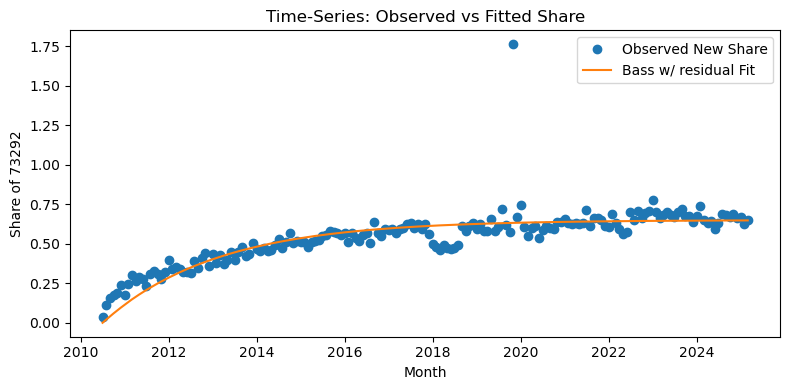

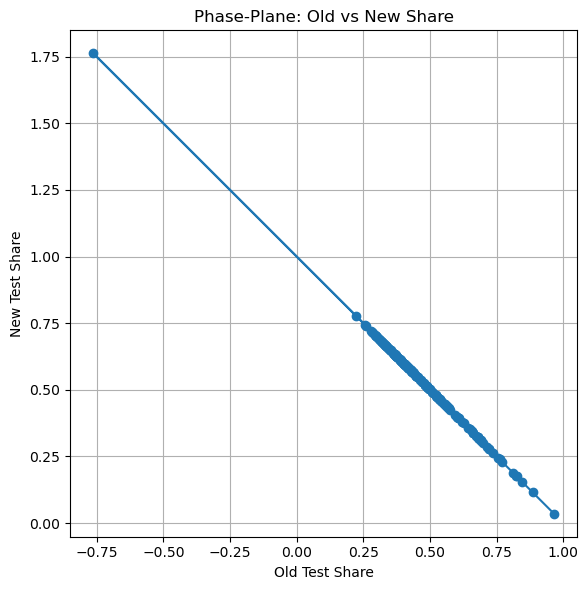

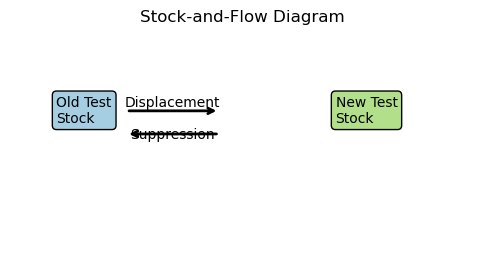

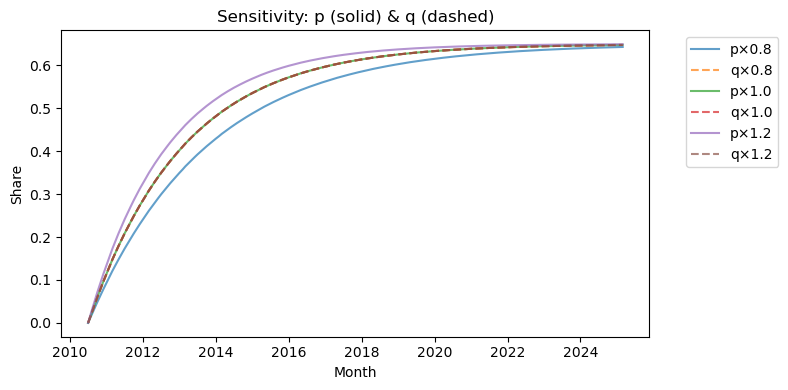

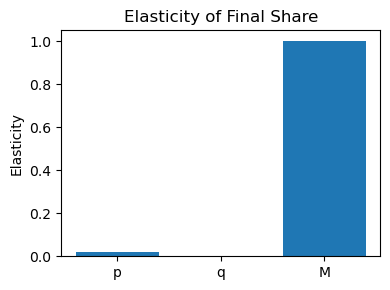

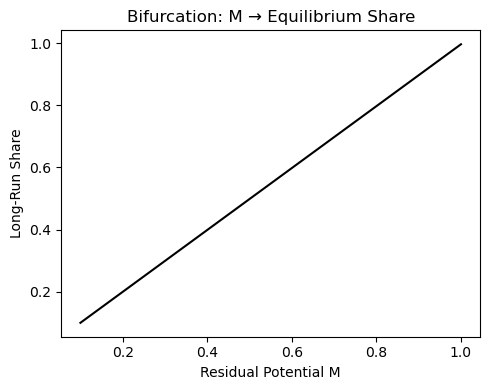

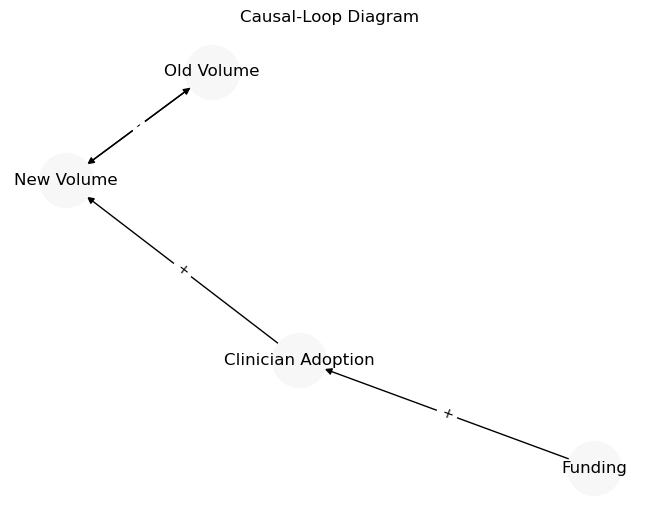

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# -----------------------------------------------------------------------------
# 1. Load & clean data
# -----------------------------------------------------------------------------
file_path = (
    "/mnt/c/Users/doughnut/OneDrive - The University of Melbourne/"
    "Phase 1 - Study 4 - Australian Genetic and Genomic Test Utilisation/"
    "MBSGeneticsBenefit_202502.feather"
)
data = pd.read_feather(file_path)
data['Item']  = data['Item'].astype(str).str.strip()
data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
data.set_index('Month', inplace=True)

# -----------------------------------------------------------------------------
# 2. Extract old/new counts and compute shares
# -----------------------------------------------------------------------------
old_ts = data.loc[data['Item']=='73287','Value'].resample('ME').sum()
new_ts = data.loc[data['Item']=='73292','Value'].resample('ME').sum()
df = pd.DataFrame({'old': old_ts, 'new': new_ts}).dropna()
df['share_new'] = df['new'] / (df['old'] + df['new'])
df['share_old'] = 1 - df['share_new']
df['t'] = np.arange(len(df)) / 12.0

# -----------------------------------------------------------------------------
# 3. Define the “Bass with residual” diffusion model (vectorized)
# -----------------------------------------------------------------------------
def bass_residual(t, p, q, M):
    t = np.asarray(t, dtype=float)
    expo = np.exp(-(p + q) * t)
    return M * (1 - expo) / (1 + (q / p) * expo)

# -----------------------------------------------------------------------------
# 4. Fit p, q, M to observed share_new
# -----------------------------------------------------------------------------
t_vals = df['t'].values
y_vals = df['share_new'].values

# Ensure initial M is strictly inside (0,1)
M0 = max(min(y_vals.max(), 0.9), 0.1)
p0 = [0.05, 0.3, M0]
bounds = ([0,    0,    0],    # p>=0, q>=0, M>=0
          [5.0,  5.0,  1.0])  # upper bounds

(p_fit, q_fit, M_fit), _ = curve_fit(
    bass_residual, t_vals, y_vals,
    p0=p0, bounds=bounds, maxfev=10000
)
df['share_fit'] = bass_residual(t_vals, p_fit, q_fit, M_fit)

# -----------------------------------------------------------------------------
# 5. Time-Series Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(df.index, df['share_new'], 'o', label='Observed New Share')
plt.plot(df.index, df['share_fit'], '-', label='Bass w/ residual Fit')
plt.xlabel('Month'); plt.ylabel('Share of 73292')
plt.title('Time-Series: Observed vs Fitted Share'); plt.legend(); plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 6. Phase-Plane Diagram (Old vs New share)
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,6))
plt.plot(df['share_old'], df['share_new'], '-o')
plt.xlabel('Old Test Share'); plt.ylabel('New Test Share')
plt.title('Phase-Plane: Old vs New Share'); plt.grid(True); plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. Stock-and-Flow Diagram (schematic)
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,3))
ax.text(0.1,0.6,'Old Test\nStock',   bbox=dict(boxstyle='round',facecolor='#a6cee3'))
ax.text(0.7,0.6,'New Test\nStock',   bbox=dict(boxstyle='round',facecolor='#b2df8a'))
ax.annotate('', xy=(0.45,0.65), xytext=(0.25,0.65),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(0.35,0.67,'Displacement', ha='center')
ax.annotate('', xy=(0.25,0.55), xytext=(0.45,0.55),
            arrowprops=dict(arrowstyle='->', lw=2))
ax.text(0.35,0.53,'Suppression', ha='center')
ax.axis('off'); plt.title('Stock-and-Flow Diagram'); plt.show()

# -----------------------------------------------------------------------------
# 8. Sensitivity / Uncertainty (Spider Plot for p & q)
# -----------------------------------------------------------------------------
deltas = [0.8, 1.0, 1.2]
plt.figure(figsize=(8,4))
for d in deltas:
    plt.plot(df.index, bass_residual(t_vals, p_fit*d, q_fit, M_fit),
             label=f'p×{d:.1f}', alpha=0.7)
    plt.plot(df.index, bass_residual(t_vals, p_fit, q_fit*d, M_fit),
             '--', label=f'q×{d:.1f}', alpha=0.7)
plt.xlabel('Month'); plt.ylabel('Share'); plt.title('Sensitivity: p (solid) & q (dashed)')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left'); plt.tight_layout(); plt.show()

# -----------------------------------------------------------------------------
# 9. Elasticity Bar Chart (final-share elasticity)
# -----------------------------------------------------------------------------
params = {'p': p_fit, 'q': q_fit, 'M': M_fit}
elasticities = {}
for name, orig in params.items():
    delta = orig * 0.1 if name!='M' else 0.05
    low, high = orig - delta, orig + delta
    args_low  = (low,  q_fit, M_fit) if name=='p' else \
                (p_fit, low,  M_fit) if name=='q' else \
                (p_fit, q_fit, low)
    args_high = (high, q_fit, M_fit) if name=='p' else \
                (p_fit, high, M_fit) if name=='q' else \
                (p_fit, q_fit, high)
    s_low  = bass_residual([t_vals[-1]], *args_low)[0]
    s_high = bass_residual([t_vals[-1]], *args_high)[0]
    elasticities[name] = ((s_high - s_low) / ((s_low + s_high)/2)) / ((high - low)/orig)

plt.figure(figsize=(4,3))
plt.bar(elasticities.keys(), elasticities.values())
plt.ylabel('Elasticity'); plt.title('Elasticity of Final Share'); plt.tight_layout(); plt.show()

# -----------------------------------------------------------------------------
#10. Bifurcation Diagram (M vs Equilibrium Share)
# -----------------------------------------------------------------------------
M_vals = np.linspace(0.1,1.0,50)
t_long = np.linspace(0, df['t'].max(), 200)
eq_shares = [bass_residual(t_long, p_fit, q_fit, M)[-1] for M in M_vals]
plt.figure(figsize=(5,4))
plt.plot(M_vals, eq_shares, '-k')
plt.xlabel('Residual Potential M'); plt.ylabel('Long-Run Share')
plt.title('Bifurcation: M → Equilibrium Share'); plt.tight_layout(); plt.show()

# -----------------------------------------------------------------------------
#11. Causal-Loop Diagram (simple networkx)
# -----------------------------------------------------------------------------
G = nx.DiGraph()
G.add_nodes_from(['Funding','Clinician Adoption','New Volume','Old Volume'])
G.add_edge('Funding','Clinician Adoption', polarity='+')
G.add_edge('Clinician Adoption','New Volume', polarity='+')
G.add_edge('New Volume','Old Volume', polarity='-')
G.add_edge('Old Volume','New Volume', polarity='-')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='#f7f7f7')
edge_labels = {(u,v): d['polarity'] for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Causal-Loop Diagram'); plt.axis('off'); plt.show()
